<a href="https://colab.research.google.com/github/iriyaverma/Brain-Tumor-Detection-using-ML/blob/main/Brain_Tumor_Detection_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
Brain Tumor Detection and Classification Using Deep Learning
Dataset: Brain Tumor MRI Dataset from Kaggle
"""

# STEP 1: SETUP AND INSTALLATIONS

In [ ]:
!pip install -q kaggle opendatasets tensorflow scikit-learn seaborn matplotlib pillow

In [ ]:
!pip install tensorflow

In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

In [ ]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU Available: True


# STEP 2: UPLOAD YOUR DATASET FOLDER

In [ ]:
print("="*60)
print("DATASET UPLOAD OPTIONS")
print("="*60)
print("\nChoose one of the following options:")
print("\nOption 1: Upload ZIP file of your dataset folder")
print("Option 2: Mount Google Drive (if dataset is in Drive)")
print("Option 3: Already have dataset in Colab")
print("\n" + "="*60)

# Option 1: Upload ZIP file
upload_choice = input("\nEnter your choice (1/2/3): ").strip()

if upload_choice == "1":
    print("\n📤 Please upload your dataset ZIP file...")
    print("(The ZIP should contain 'Training' and 'Testing' folders)")
    from google.colab import files
    uploaded = files.upload()

    # Get the uploaded file name
    zip_file = list(uploaded.keys())[0]
    print(f"\n✅ Uploaded: {zip_file}")

    # Unzip the dataset
    print("\n📦 Extracting dataset...")
    !unzip -q "{zip_file}" -d brain_tumor_data
    print("✅ Extraction complete!")

elif upload_choice == "2":
    print("\n📁 Mounting Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive')

    print("\n📝 Enter the path to your dataset folder in Google Drive")
    print("Example: /content/drive/MyDrive/brain_tumor_dataset")
    dataset_path = input("Enter path: ").strip()

    # Copy from Drive to Colab
    print("\n📋 Copying dataset to Colab workspace...")
    !cp -r "{dataset_path}" brain_tumor_data
    print("✅ Copy complete!")

elif upload_choice == "3":
    print("\n📝 Enter the path to your dataset folder")
    print("Example: /content/my_dataset")
    dataset_path = input("Enter path: ").strip()

    # Rename or use existing path
    if dataset_path != "brain_tumor_data":
        !cp -r "{dataset_path}" brain_tumor_data
    print("✅ Dataset path set!")

else:
    print("❌ Invalid choice. Please run the cell again.")

print("\n" + "="*60)
print("Checking dataset structure...")
print("="*60)
!ls -R brain_tumor_data

# STEP 3: DATA EXPLORATION AND VISUALIZATION

In [ ]:
# Define paths
data_dir = 'brain_tumor_data/Training'
test_dir = 'brain_tumor_data/Testing'

In [ ]:
# Get class names
classes = sorted(os.listdir(data_dir))
print(f"Classes found: {classes}")
print(f"Number of classes: {len(classes)}")

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4


In [ ]:
# Count images per class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images(data_dir)
test_counts = count_images(test_dir)

print("\nTraining set distribution:")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")

print("\nTesting set distribution:")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")


Training set distribution:
notumor: 1595 images
meningioma: 1339 images
pituitary: 1457 images
glioma: 1321 images

Testing set distribution:
notumor: 405 images
meningioma: 306 images
pituitary: 300 images
glioma: 300 images


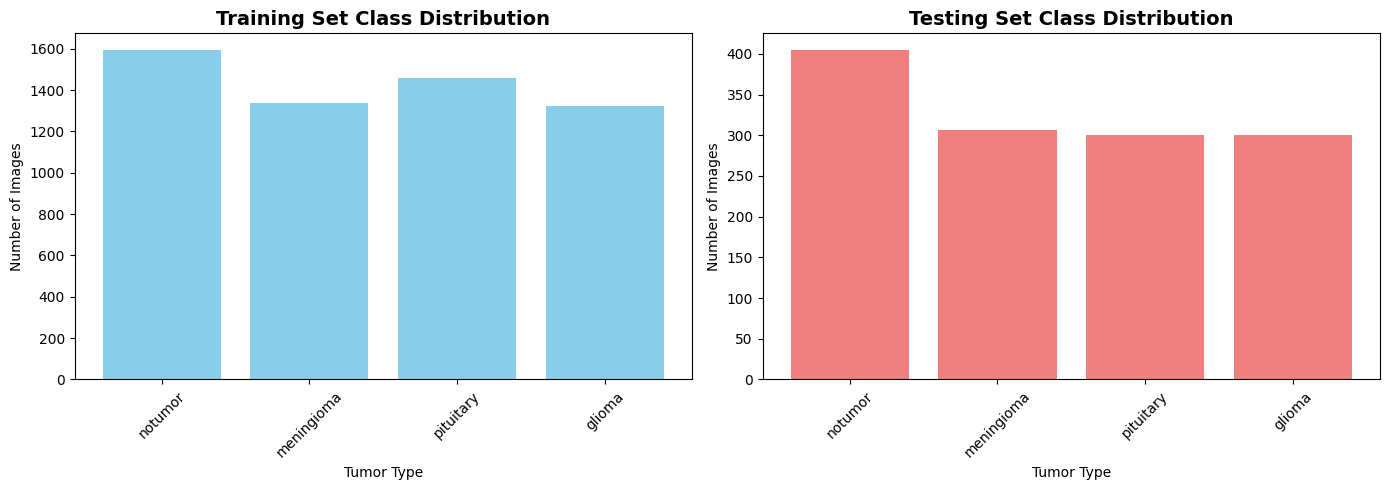

In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tumor Type')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(test_counts.keys(), test_counts.values(), color='lightcoral')
axes[1].set_title('Testing Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tumor Type')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

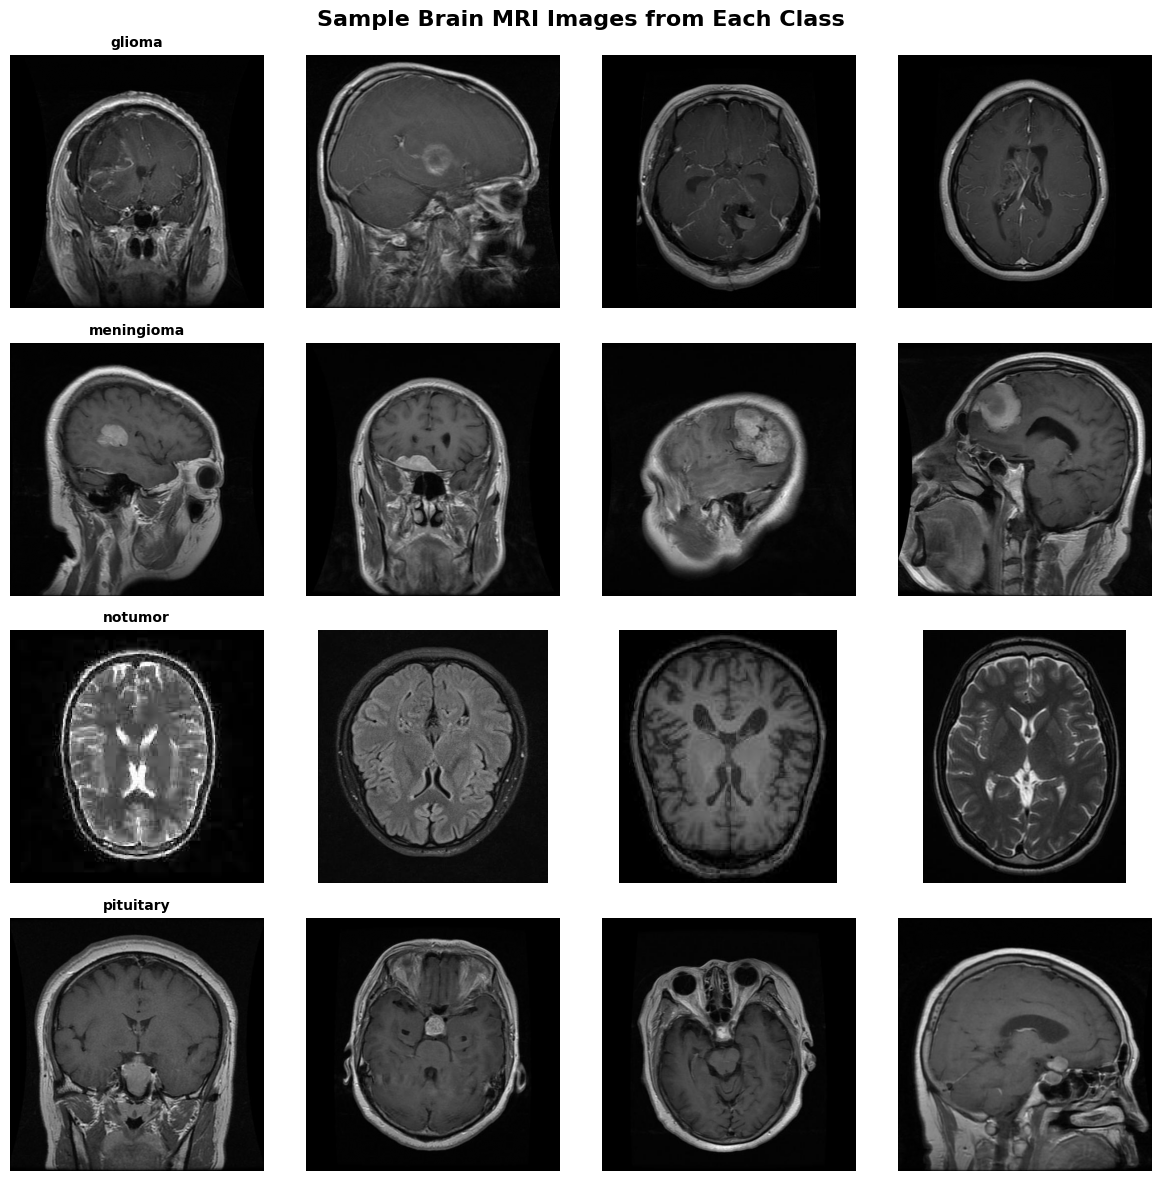

In [ ]:
# Visualize sample images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample Brain MRI Images from Each Class', fontsize=16, fontweight='bold')

for i, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)[:4]

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# STEP 4: DATA PREPROCESSING AND AUGMENTATION

In [ ]:
# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
# Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Training samples: 4571
Validation samples: 1141
Test samples: 1311
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# STEP 5: BUILD DEEP LEARNING MODELS

In [ ]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4):
    """Custom CNN model"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def create_transfer_model(base_model_name='EfficientNetB0', input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4):
    """Transfer learning model"""
    # Load pre-trained model
    if base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model layers
    base_model.trainable = False

    # Create model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
# Create models
print("\n" + "="*60)
print("Creating Custom CNN Model...")
print("="*60)
cnn_model = create_cnn_model(num_classes=len(classes))
cnn_model.summary()


Creating Custom CNN Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,002,148 (103.01 MB)

 Trainable params: 26,998,692 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
print("\n" + "="*60)
print("Creating Transfer Learning Model (VGG16)...")
print("="*60)
vgg_model = create_transfer_model('VGG16', num_classes=len(classes))
vgg_model.summary()


Creating Transfer Learning Model (VGG16)...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

# STEP 6: COMPILE AND TRAIN MODELS

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
checkpoint_cnn = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
checkpoint_vgg = ModelCheckpoint('best_vgg_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

callbacks_cnn = [early_stop, reduce_lr, checkpoint_cnn]
callbacks_vgg = [early_stop, reduce_lr, checkpoint_vgg]

In [ ]:
# Compile Custom CNN
print("\n" + "="*60)
print("Compiling Custom CNN Model...")
print("="*60)
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)


Compiling Custom CNN Model...


In [ ]:
# Train Custom CNN
print("\n" + "="*60)
print("Training Custom CNN Model...")
print("="*60)

history_cnn = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks_cnn,
    verbose=1
)


Training Custom CNN Model...
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.5356 - auc: 0.7922 - loss: 1.2820 - precision: 0.5731 - recall: 0.4801
Epoch 1: val_accuracy improved from -inf to 0.27958, saving model to best_cnn_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 149s 802ms/step - accuracy: 0.5361 - auc: 0.7926 - loss: 1.2803 - precision: 0.5736 - recall: 0.4806 - val_accuracy: 0.2796 - val_auc: 0.5542 - val_loss: 2.2067 - val_precision: 0.2796 - val_recall: 0.2796 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.6944 - auc: 0.8987 - loss: 0.8133 - precision: 0.7283 - recall: 0.6542
Epoch 2: val_accuracy did not improve from 0.27958
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 535ms/step - accuracy: 0.6945 - auc: 0.8987 - loss: 0.8130 - precision: 0.7284 - recall: 0.6543 - val_accuracy: 0.2752 - val_auc: 0.5299 - val_loss: 3.0959 - val_precision: 0.2755 - val_recall: 0.2743 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.7550 - auc: 0.9315 - loss: 0.6458 - precision: 0.7825 - recall: 0.7159
Epoch 3: val_accuracy improved from 0.27958 to 0.35320, saving model to best_cnn_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 596ms/step - accuracy: 0.7546 - auc: 0.9314 - loss: 0.6466 - precision: 0.7823 - recall: 0.7155 - val_accuracy: 0.3532 - val_auc: 0.6035 - val_loss: 3.7545 - val_precision: 0.3553 - val_recall: 0.3497 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7126 - auc: 0.9089 - loss: 0.7355 - precision: 0.7505 - recall: 0.6466
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.35320
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 550ms/step - accuracy: 0.7127 - auc: 0.9090 - loss: 0.7352 - precision: 0.7506 - recall: 0.6467 - val_accuracy: 0.3260 - val_auc: 0.6147 - val_loss: 2.4000 - val_precision: 0.3396 - val_recall: 0.2989 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7494 - auc: 0.9308 - loss: 0.6395 - precision: 0.7857 - recall: 0.6962
Epoch 5: val_accuracy improved from 0.35320 to 0.45486, saving model to best_c

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 582ms/step - accuracy: 0.7495 - auc: 0.9308 - loss: 0.6392 - precision: 0.7858 - recall: 0.6963 - val_accuracy: 0.4549 - val_auc: 0.7341 - val_loss: 1.9756 - val_precision: 0.4675 - val_recall: 0.4479 - learning_rate: 5.0000e-04
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7801 - auc: 0.9433 - loss: 0.5710 - precision: 0.8128 - recall: 0.7445
Epoch 6: val_accuracy improved from 0.45486 to 0.57844, saving model to best_cnn_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 586ms/step - accuracy: 0.7802 - auc: 0.9433 - loss: 0.5709 - precision: 0.8129 - recall: 0.7446 - val_accuracy: 0.5784 - val_auc: 0.8329 - val_loss: 1.1534 - val_precision: 0.6028 - val_recall: 0.5574 - learning_rate: 5.0000e-04
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7927 - auc: 0.9486 - loss: 0.5434 - precision: 0.8236 - recall: 0.7497
Epoch 7: val_accuracy did not improve from 0.57844
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 548ms/step - accuracy: 0.7928 - auc: 0.9487 - loss: 0.5433 - precision: 0.8237 - recall: 0.7498 - val_accuracy: 0.5749 - val_auc: 0.8160 - val_loss: 1.4147 - val_precision: 0.5825 - val_recall: 0.5600 - learning_rate: 5.0000e-04
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8368 - auc: 0.9648 - loss: 0.4504 - precision: 0.8641 - recall: 0.8087
Epoch 8: val_accuracy did not improve from 0.57844
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 539ms/step - accuracy: 0.8368 - auc: 0.9648 - loss: 0.4505 - pr

In [ ]:
# Compile VGG16 Model
print("\n" + "="*60)
print("Compiling VGG16 Transfer Learning Model...")
print("="*60)
vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)


Compiling VGG16 Transfer Learning Model...


In [ ]:
# Train VGG16 Model
print("\n" + "="*60)
print("Training VGG16 Transfer Learning Model...")
print("="*60)

history_vgg = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks_vgg,
    verbose=1
)


Training VGG16 Transfer Learning Model...
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6524 - auc: 0.8651 - loss: 1.0214 - precision: 0.6740 - recall: 0.6168
Epoch 1: val_accuracy improved from -inf to 0.50394, saving model to best_vgg_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 129s 764ms/step - accuracy: 0.6530 - auc: 0.8655 - loss: 1.0196 - precision: 0.6746 - recall: 0.6176 - val_accuracy: 0.5039 - val_auc: 0.7285 - val_loss: 1.2607 - val_precision: 0.6117 - val_recall: 0.3216 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8004 - auc: 0.9498 - loss: 0.5726 - precision: 0.8137 - recall: 0.7806
Epoch 2: val_accuracy improved from 0.50394 to 0.64154, saving model to best_vgg_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 566ms/step - accuracy: 0.8005 - auc: 0.9498 - loss: 0.5724 - precision: 0.8138 - recall: 0.7808 - val_accuracy: 0.6415 - val_auc: 0.8878 - val_loss: 0.8057 - val_precision: 0.7047 - val_recall: 0.5416 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8108 - auc: 0.9563 - loss: 0.5196 - precision: 0.8274 - recall: 0.7937
Epoch 3: val_accuracy improved from 0.64154 to 0.71166, saving model to best_vgg_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 563ms/step - accuracy: 0.8109 - auc: 0.9563 - loss: 0.5193 - precision: 0.8275 - recall: 0.7938 - val_accuracy: 0.7117 - val_auc: 0.9113 - val_loss: 0.7500 - val_precision: 0.7429 - val_recall: 0.6862 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8342 - auc: 0.9665 - loss: 0.4484 - precision: 0.8489 - recall: 0.8160
Epoch 4: val_accuracy improved from 0.71166 to 0.79755, saving model to best_vgg_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.8342 - auc: 0.9665 - loss: 0.4483 - precision: 0.8489 - recall: 0.8160 - val_accuracy: 0.7975 - val_auc: 0.9445 - val_loss: 0.5890 - val_precision: 0.8200 - val_recall: 0.7625 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8488 - auc: 0.9718 - loss: 0.4027 - precision: 0.8587 - recall: 0.8313
Epoch 5: val_accuracy did not improve from 0.79755
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.8488 - auc: 0.9718 - loss: 0.4028 - precision: 0.8587 - recall: 0.8313 - val_accuracy: 0.7704 - val_auc: 0.9365 - val_loss: 0.6735 - val_precision: 0.7879 - val_recall: 0.7555 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8592 - auc: 0.9733 - loss: 0.3872 - precision: 0.8722 - recall: 0.8440
Epoch 6: val_accuracy did not improve from 0.79755
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 577ms/step - accuracy: 0.8592 - auc: 0.9733 - loss: 0.3872 - precision:

143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.8615 - auc: 0.9753 - loss: 0.3674 - precision: 0.8746 - recall: 0.8442 - val_accuracy: 0.8221 - val_auc: 0.9517 - val_loss: 0.5488 - val_precision: 0.8506 - val_recall: 0.8037 - learning_rate: 5.0000e-04
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8644 - auc: 0.9771 - loss: 0.3550 - precision: 0.8794 - recall: 0.8503
Epoch 9: val_accuracy improved from 0.82209 to 0.82734, saving model to best_vgg_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 569ms/step - accuracy: 0.8644 - auc: 0.9771 - loss: 0.3550 - precision: 0.8795 - recall: 0.8503 - val_accuracy: 0.8273 - val_auc: 0.9564 - val_loss: 0.5268 - val_precision: 0.8464 - val_recall: 0.8019 - learning_rate: 5.0000e-04
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8774 - auc: 0.9799 - loss: 0.3348 - precision: 0.8913 - recall: 0.8597
Epoch 10: val_accuracy did not improve from 0.82734
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 567ms/step - accuracy: 0.8773 - auc: 0.9799 - loss: 0.3349 - precision: 0.8912 - recall: 0.8596 - val_accuracy: 0.8081 - val_auc: 0.9465 - val_loss: 0.5905 - val_precision: 0.8304 - val_recall: 0.7809 - learning_rate: 5.0000e-04
Epoch 11/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8781 - auc: 0.9791 - loss: 0.3333 - precision: 0.8934 - recall: 0.8606
Epoch 11: val_accuracy did not improve from 0.82734
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 560ms/step - accuracy: 0.8781 - auc: 0.9791 - loss: 0.3333 

143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 559ms/step - accuracy: 0.8817 - auc: 0.9795 - loss: 0.3316 - precision: 0.8966 - recall: 0.8686 - val_accuracy: 0.8344 - val_auc: 0.9606 - val_loss: 0.4901 - val_precision: 0.8540 - val_recall: 0.8151 - learning_rate: 5.0000e-04
Epoch 13/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8718 - auc: 0.9793 - loss: 0.3332 - precision: 0.8834 - recall: 0.8564
Epoch 13: val_accuracy did not improve from 0.83436
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 567ms/step - accuracy: 0.8718 - auc: 0.9793 - loss: 0.3332 - precision: 0.8834 - recall: 0.8564 - val_accuracy: 0.8344 - val_auc: 0.9590 - val_loss: 0.5057 - val_precision: 0.8497 - val_recall: 0.8177 - learning_rate: 5.0000e-04
Epoch 14/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8854 - auc: 0.9818 - loss: 0.3174 - precision: 0.8969 - recall: 0.8715
Epoch 14: val_accuracy did not improve from 0.83436
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.8854 - auc: 0.9818 - loss: 0.3174 

# STEP 7: VISUALIZE TRAINING HISTORY

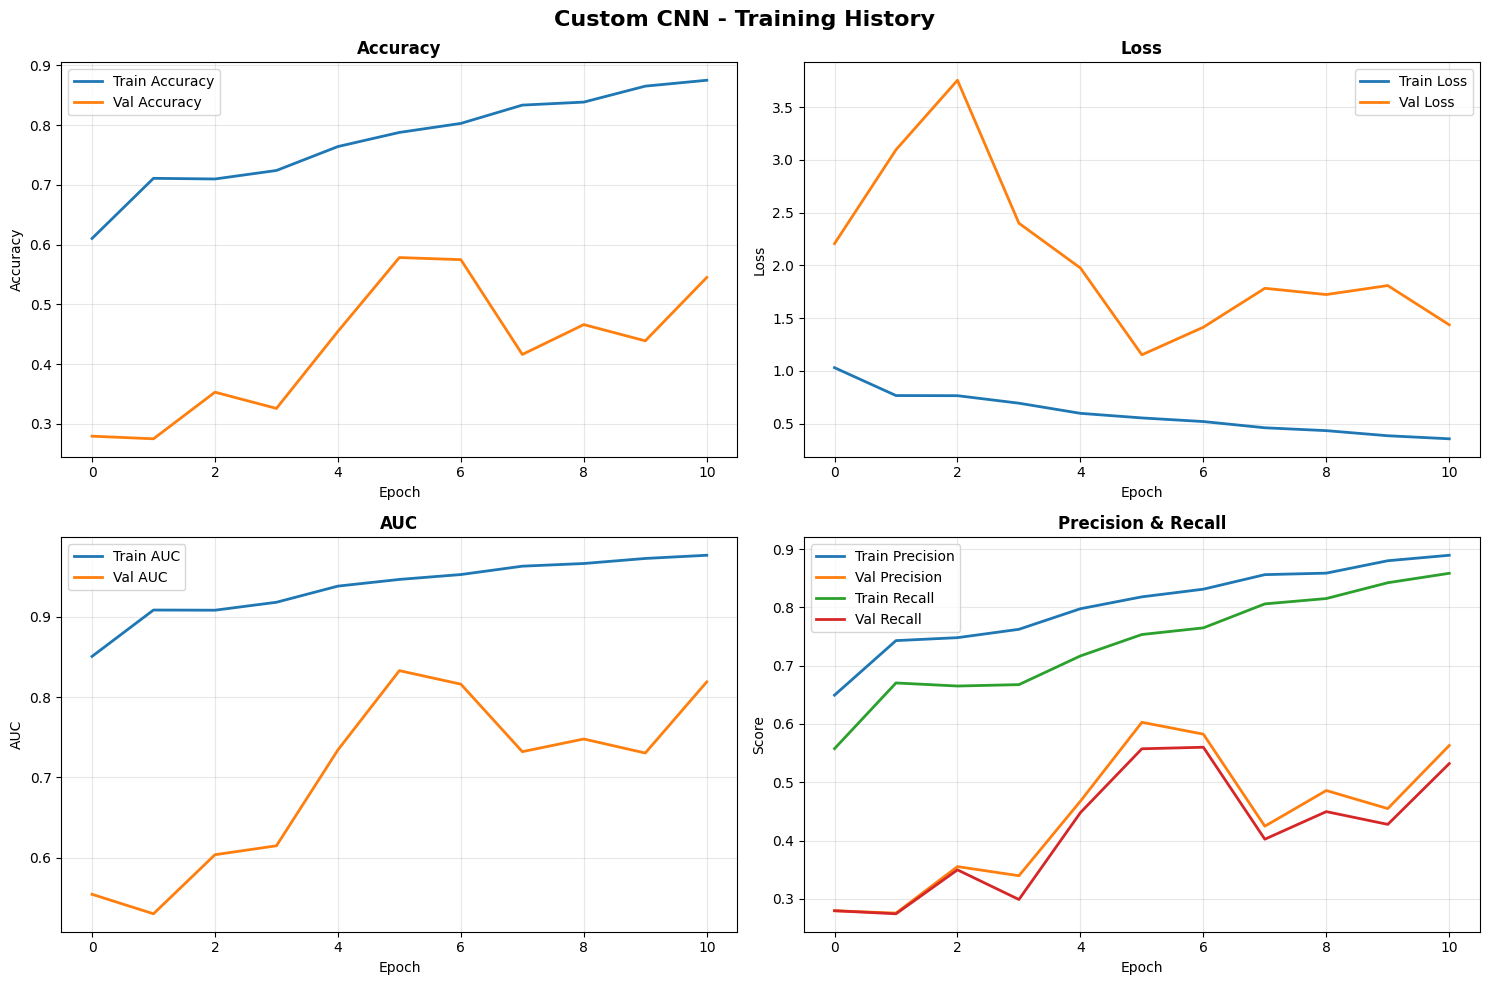

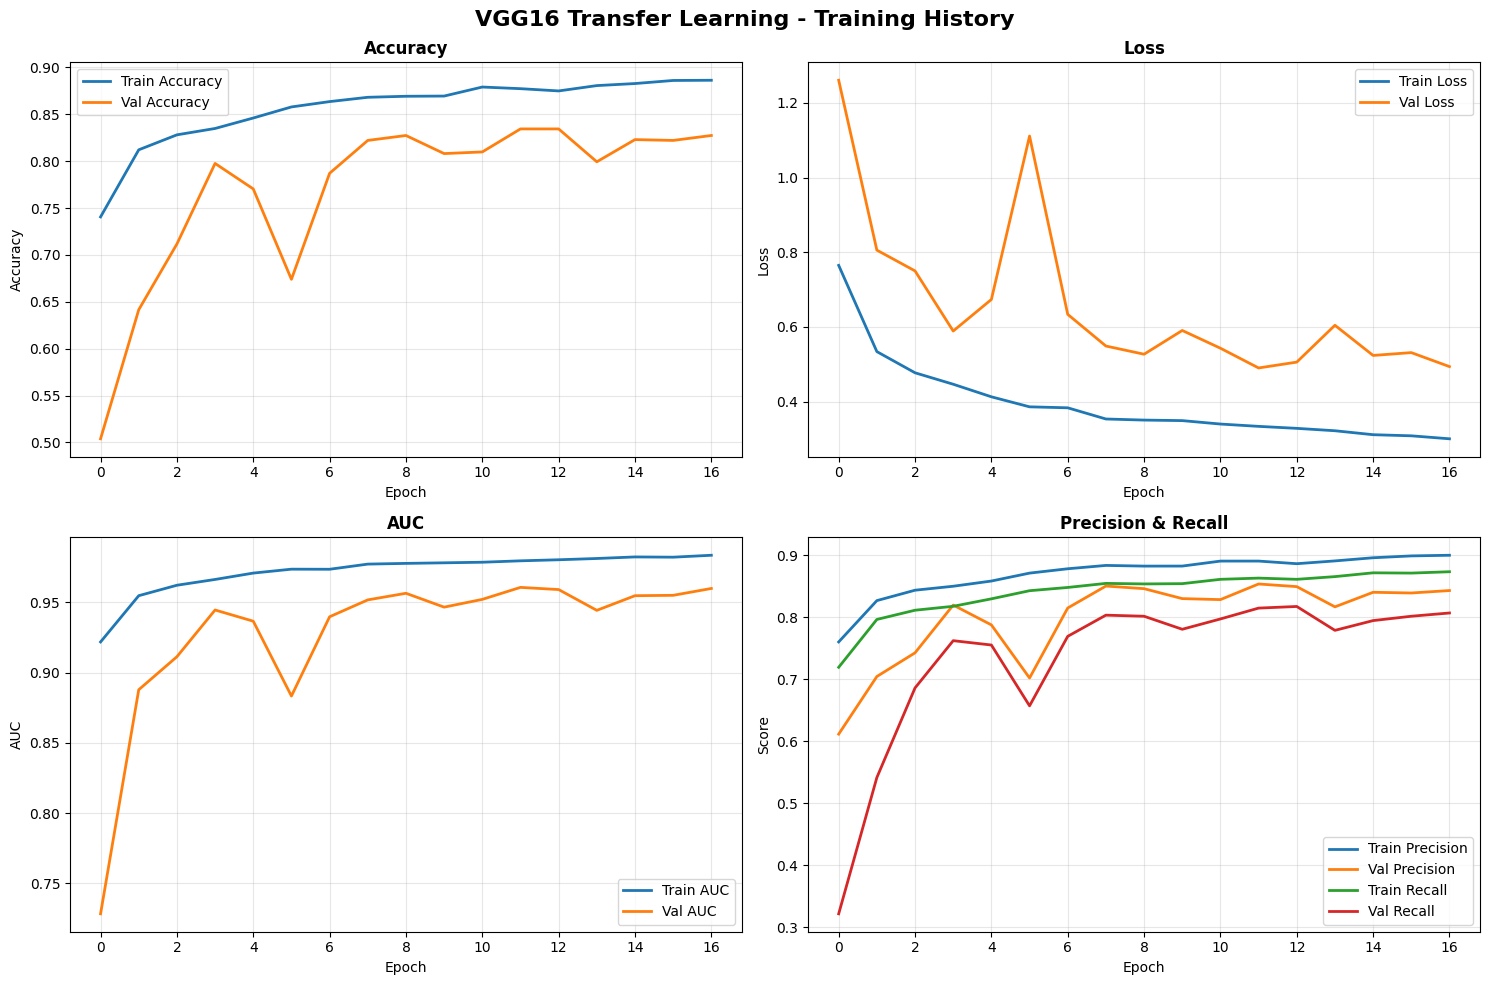

In [ ]:
def plot_training_history(history, model_name):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 0].set_title('Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # AUC
    axes[1, 0].plot(history.history['auc'], label='Train AUC', linewidth=2)
    axes[1, 0].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    axes[1, 0].set_title('AUC', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Precision and Recall
    axes[1, 1].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Precision & Recall', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, 'Custom CNN')
plot_training_history(history_vgg, 'VGG16 Transfer Learning')

# STEP 8: EVALUATE MODELS ON TEST SET

In [ ]:
def evaluate_model(model, test_gen, model_name):
    """Evaluate model and display results"""
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}...")
    print('='*60)

    # Predictions
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Calculate metrics
    test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_gen, verbose=0)

    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(test_gen.class_indices.keys()),
                yticklabels=list(test_gen.class_indices.keys()),
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return predictions, y_pred, y_true


Evaluating Custom CNN...
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step

Test Accuracy: 0.6682
Test Loss: 0.9729
Test AUC: 0.8920
Test Precision: 0.6761
Test Recall: 0.6529

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.14      0.25       300
  meningioma       0.46      0.54      0.50       306
     notumor       0.80      0.96      0.87       405
   pituitary       0.66      0.94      0.77       300

    accuracy                           0.67      1311
   macro avg       0.73      0.64      0.60      1311
weighted avg       0.73      0.67      0.62      1311



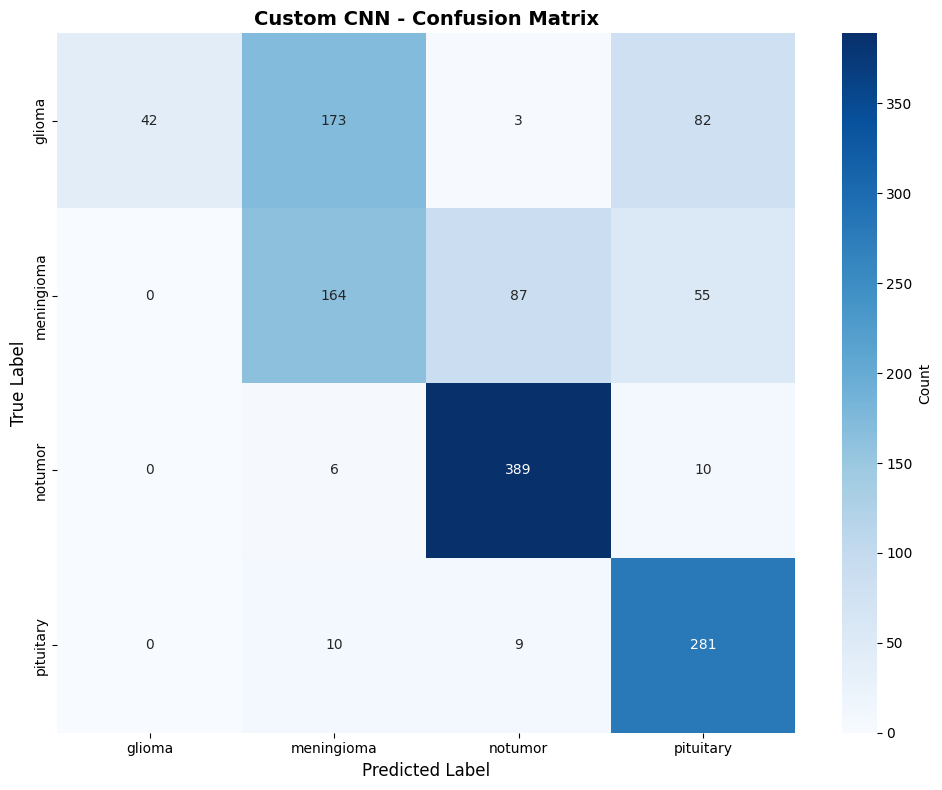


Evaluating VGG16 Transfer Learning...
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 575ms/step

Test Accuracy: 0.8185
Test Loss: 0.5479
Test AUC: 0.9601
Test Precision: 0.8349
Test Recall: 0.8024

Classification Report:
              precision    recall  f1-score   support

      glioma       0.86      0.73      0.79       300
  meningioma       0.79      0.54      0.64       306
     notumor       0.91      0.96      0.94       405
   pituitary       0.71      0.99      0.83       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.80      1311
weighted avg       0.83      0.82      0.81      1311



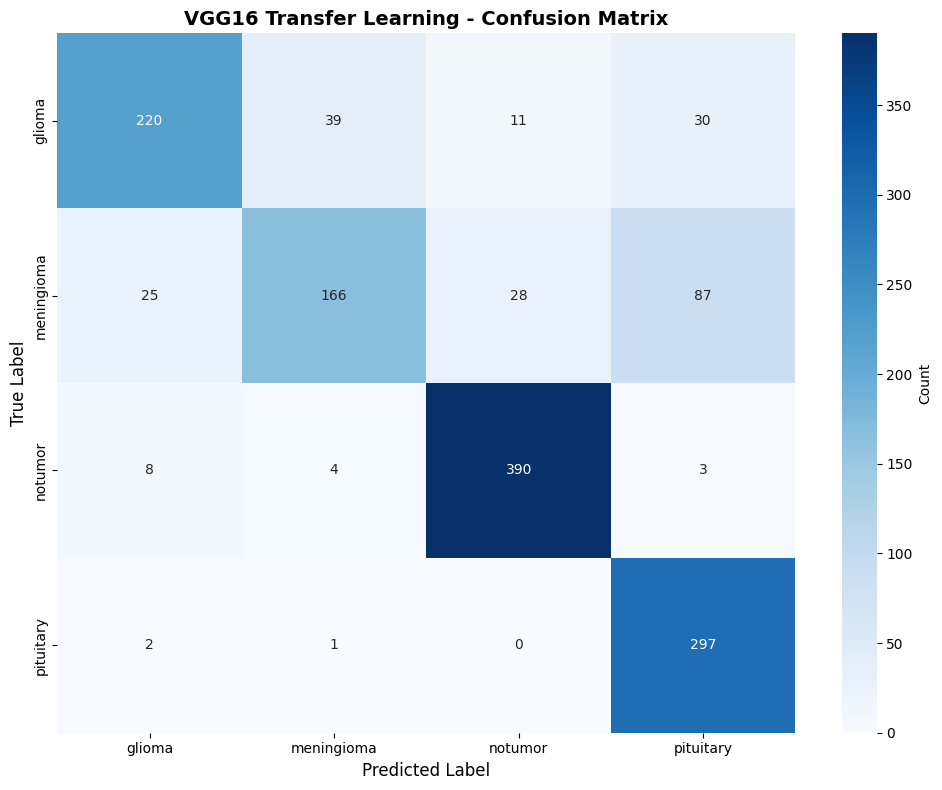

In [ ]:
cnn_pred, cnn_y_pred, cnn_y_true = evaluate_model(cnn_model, test_generator, 'Custom CNN')
vgg_pred, vgg_y_pred, vgg_y_true = evaluate_model(vgg_model, test_generator, 'VGG16 Transfer Learning')

# STEP 9: VISUALIZE PREDICTIONS

In [ ]:
def visualize_predictions(model, test_gen, num_images=16):
    """Visualize model predictions"""
    test_gen.reset()
    x_batch, y_batch = next(test_gen)
    predictions = model.predict(x_batch)

    class_names = list(test_gen.class_indices.keys())

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i >= len(x_batch):
            break

        ax.imshow(x_batch[i])

        true_label = class_names[np.argmax(y_batch[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100

        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                    color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Visualizing Custom CNN Predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


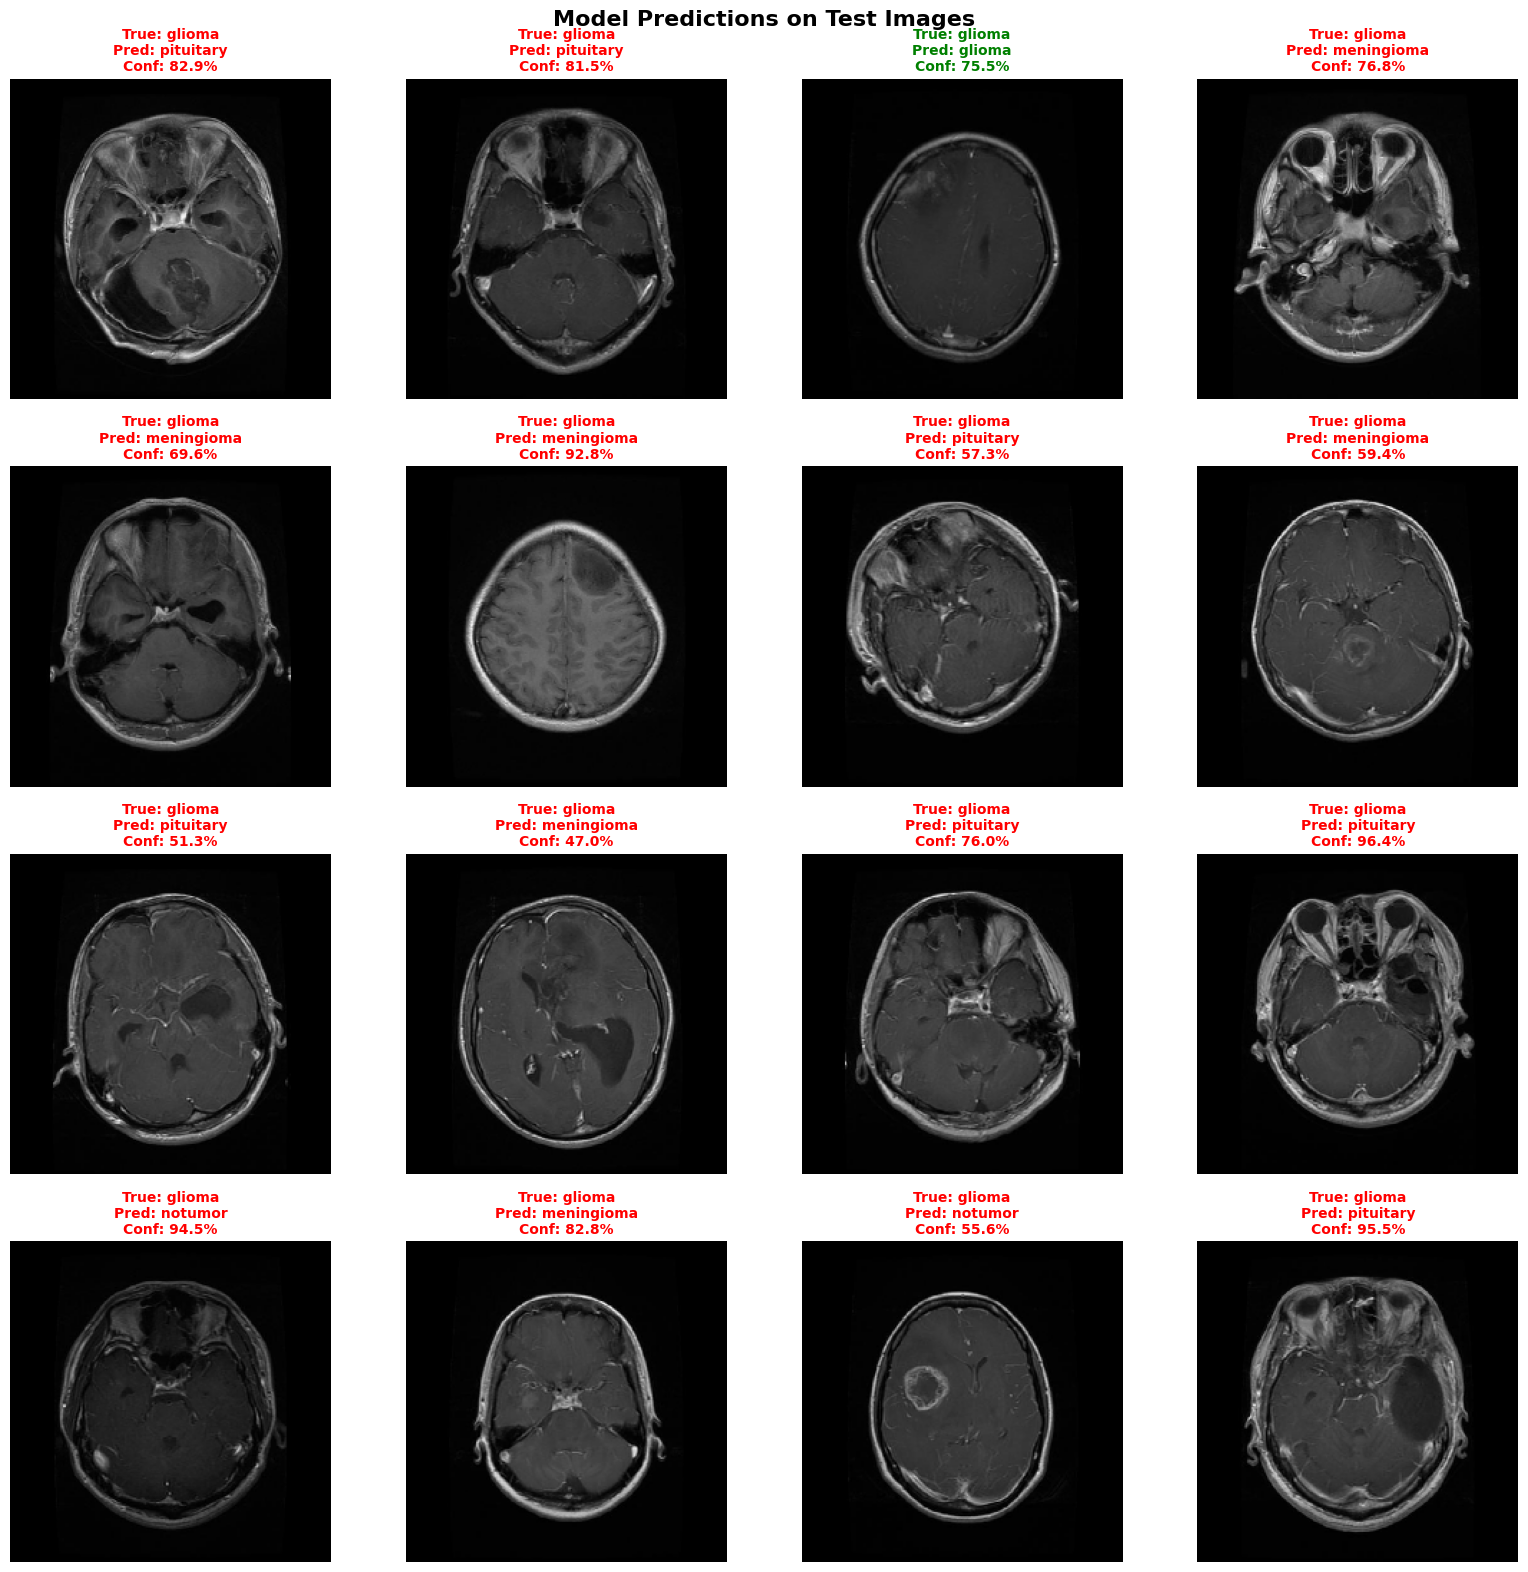

In [ ]:
print("\nVisualizing Custom CNN Predictions...")
visualize_predictions(cnn_model, test_generator)


Visualizing VGG16 Predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


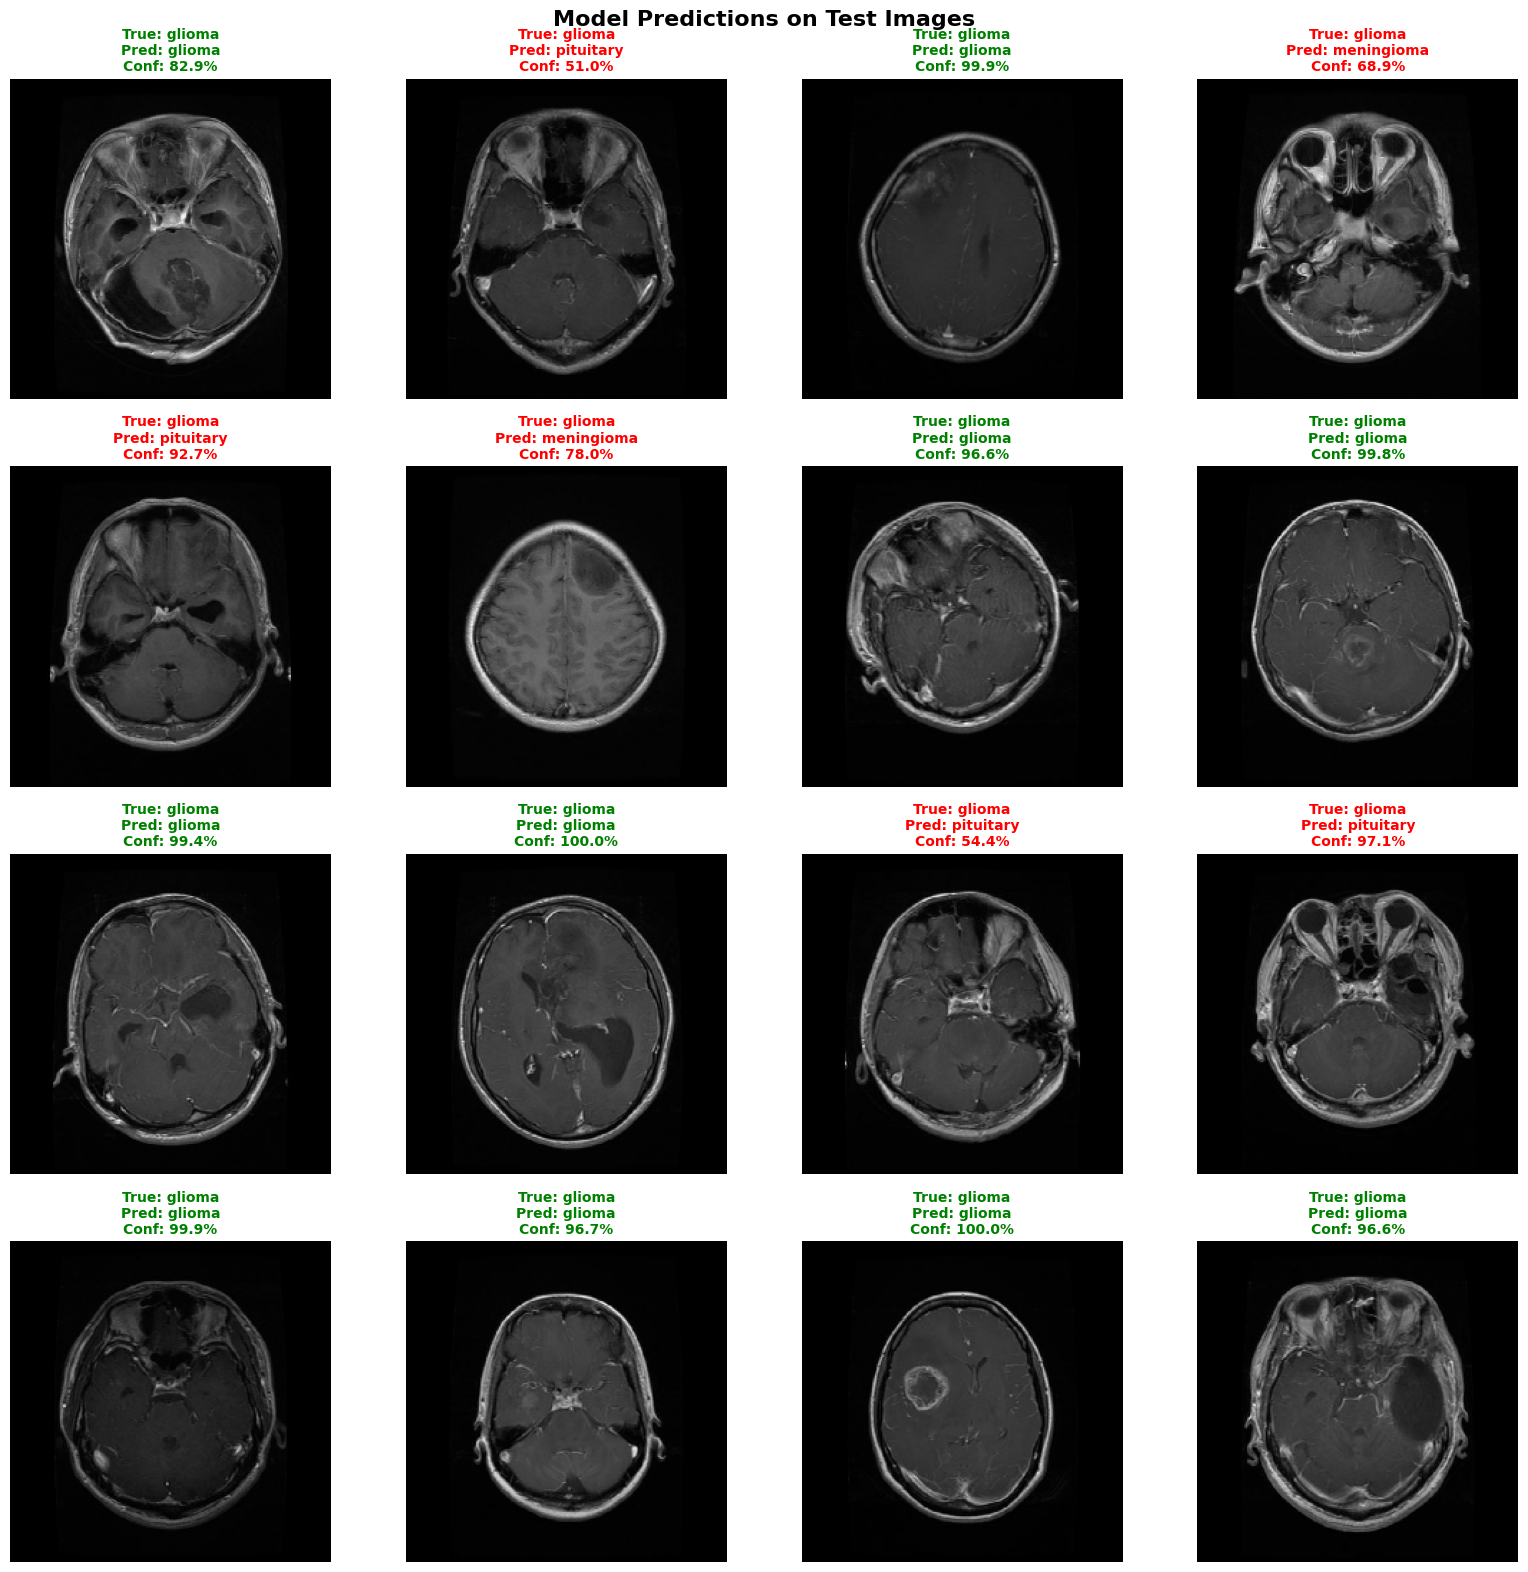

In [ ]:
print("\nVisualizing VGG16 Predictions...")
visualize_predictions(vgg_model, test_generator)

# STEP 10: SAVE MODELS

In [ ]:
# Save models
cnn_model.save('brain_tumor_cnn_model.h5')
vgg_model.save('brain_tumor_vgg16_model.h5')

print("\n" + "="*60)
print("Models saved successfully!")
print("="*60)
print("Files saved:")
print("1. brain_tumor_cnn_model.h5")
print("2. brain_tumor_vgg16_model.h5")
print("3. best_cnn_model.h5 (best CNN during training)")
print("4. best_vgg_model.h5 (best VGG16 during training)")


Models saved successfully!
Files saved:
1. brain_tumor_cnn_model.h5
2. brain_tumor_vgg16_model.h5
3. best_cnn_model.h5 (best CNN during training)
4. best_vgg_model.h5 (best VGG16 during training)


# STEP 11: DETAILED MODEL COMPARISON & ACTIVATION FUNCTION ANALYSIS

In [ ]:
# Compare models
results_df = pd.DataFrame({
    'Model': ['Custom CNN', 'VGG16 Transfer Learning'],
    'Test Accuracy': [
        accuracy_score(cnn_y_true, cnn_y_pred),
        accuracy_score(vgg_y_true, vgg_y_pred)
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))


MODEL COMPARISON
                  Model  Test Accuracy
             Custom CNN       0.668192
VGG16 Transfer Learning       0.818459


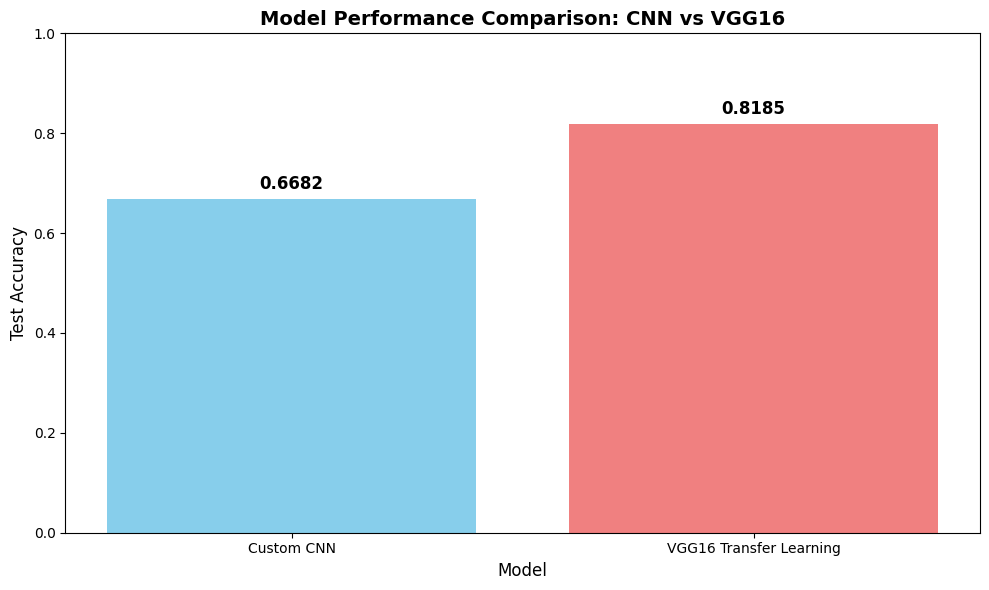

In [ ]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Test Accuracy'], color=['skyblue', 'lightcoral'])
plt.title('Model Performance Comparison: CNN vs VGG16', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim([0, 1])
for i, v in enumerate(results_df['Test Accuracy']):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# STEP 12: ACTIVATION FUNCTION ANALYSIS


ACTIVATION FUNCTIONS USED IN MODELS

📊 CUSTOM CNN MODEL - Activation Functions:
------------------------------------------------------------

1. CONVOLUTIONAL LAYERS (All 8 Conv2D layers):
   ✓ Activation: ReLU (Rectified Linear Unit)
   ✓ Formula: f(x) = max(0, x)
   ✓ Location: Conv2D layers in Blocks 1, 2, 3, and 4
   ✓ Purpose: Introduces non-linearity, helps learn complex patterns
   ✓ Why ReLU: Fast computation, reduces vanishing gradient problem

2. DENSE HIDDEN LAYERS (2 layers):
   ✓ Activation: ReLU
   ✓ Location: Dense(512) and Dense(256) layers
   ✓ Purpose: Non-linear transformations in fully connected layers

3. OUTPUT LAYER:
   ✓ Activation: Softmax
   ✓ Formula: softmax(x_i) = exp(x_i) / Σ(exp(x_j))
   ✓ Location: Final Dense layer with 4 neurons
   ✓ Purpose: Converts logits to probability distribution
   ✓ Output: 4 probabilities (sum = 1) for each tumor class


📊 VGG16 TRANSFER LEARNING MODEL - Activation Functions:
--------------------------------------------------

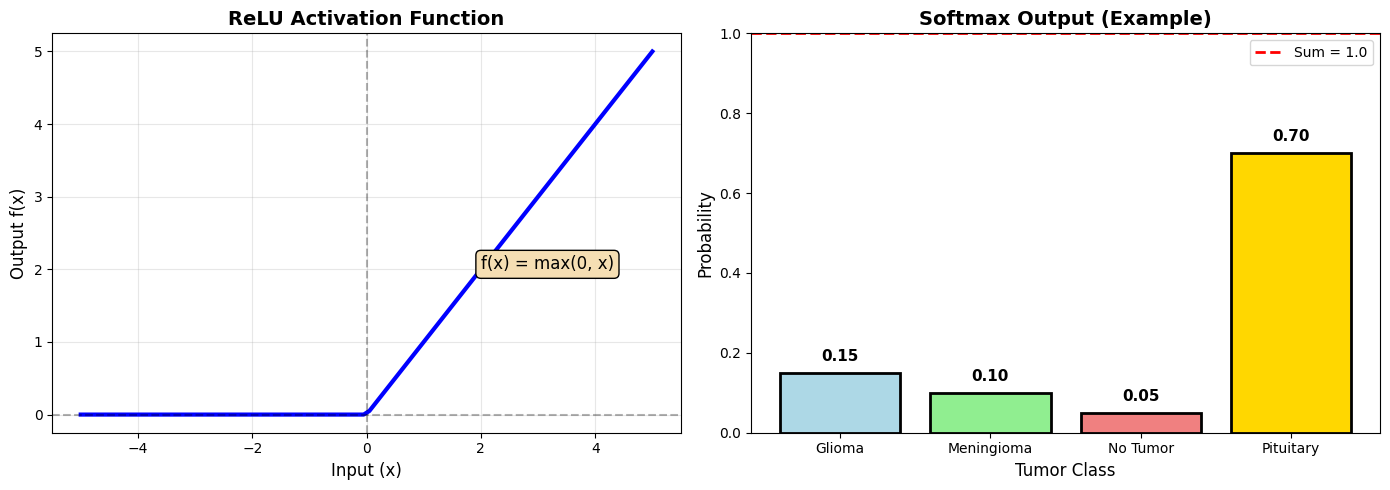


PROJECT COMPLETED SUCCESSFULLY!


In [ ]:
print("\n" + "="*60)
print("ACTIVATION FUNCTIONS USED IN MODELS")
print("="*60)

print("\n📊 CUSTOM CNN MODEL - Activation Functions:")
print("-" * 60)
print("\n1. CONVOLUTIONAL LAYERS (All 8 Conv2D layers):")
print("   ✓ Activation: ReLU (Rectified Linear Unit)")
print("   ✓ Formula: f(x) = max(0, x)")
print("   ✓ Location: Conv2D layers in Blocks 1, 2, 3, and 4")
print("   ✓ Purpose: Introduces non-linearity, helps learn complex patterns")
print("   ✓ Why ReLU: Fast computation, reduces vanishing gradient problem")

print("\n2. DENSE HIDDEN LAYERS (2 layers):")
print("   ✓ Activation: ReLU")
print("   ✓ Location: Dense(512) and Dense(256) layers")
print("   ✓ Purpose: Non-linear transformations in fully connected layers")

print("\n3. OUTPUT LAYER:")
print("   ✓ Activation: Softmax")
print("   ✓ Formula: softmax(x_i) = exp(x_i) / Σ(exp(x_j))")
print("   ✓ Location: Final Dense layer with 4 neurons")
print("   ✓ Purpose: Converts logits to probability distribution")
print("   ✓ Output: 4 probabilities (sum = 1) for each tumor class")

print("\n" + "="*60)
print("\n📊 VGG16 TRANSFER LEARNING MODEL - Activation Functions:")
print("-" * 60)
print("\n1. VGG16 BASE (Pre-trained layers):")
print("   ✓ Activation: ReLU")
print("   ✓ Location: All 13 convolutional layers in VGG16")
print("   ✓ Blocks: 5 blocks with 2-3 Conv layers each")
print("   ✓ Architecture:")
print("      - Block 1: 2 Conv layers (64 filters)")
print("      - Block 2: 2 Conv layers (128 filters)")
print("      - Block 3: 3 Conv layers (256 filters)")
print("      - Block 4: 3 Conv layers (512 filters)")
print("      - Block 5: 3 Conv layers (512 filters)")

print("\n2. CUSTOM CLASSIFICATION HEAD:")
print("   ✓ Dense(512): ReLU activation")
print("   ✓ Dense(256): ReLU activation")
print("   ✓ Dense(4): Softmax activation (output layer)")

print("\n" + "="*60)
print("\n🔬 ACTIVATION FUNCTION COMPARISON:")
print("-" * 60)

activation_comparison = pd.DataFrame({
    'Activation': ['ReLU', 'Softmax'],
    'Used In': ['Hidden Layers', 'Output Layer'],
    'Formula': ['max(0, x)', 'exp(x_i)/Σexp(x_j)'],
    'Range': ['[0, ∞)', '[0, 1]'],
    'Purpose': ['Non-linearity & Feature Learning', 'Multi-class Probability'],
    'Advantages': ['Fast, No vanishing gradient', 'Probability distribution']
})

print(activation_comparison.to_string(index=False))

print("\n" + "="*60)
print("\n📈 ARCHITECTURE COMPARISON:")
print("-" * 60)

# Create detailed comparison
comparison_data = {
    'Aspect': [
        'Total Layers',
        'Conv Layers',
        'Dense Layers',
        'Parameters',
        'Pre-trained',
        'Training Speed',
        'Memory Usage',
        'Overfitting Risk'
    ],
    'Custom CNN': [
        '~20 layers',
        '8 Conv2D',
        '3 Dense',
        '~10-15M params',
        'No',
        'Moderate',
        'Lower',
        'Higher'
    ],
    'VGG16': [
        '~20 layers',
        '13 Conv2D (VGG16)',
        '3 Dense (custom)',
        '~15-20M params',
        'Yes (ImageNet)',
        'Faster convergence',
        'Higher',
        'Lower'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*60)
print("\n💡 KEY INSIGHTS:")
print("-" * 60)
print("\n1. ReLU Activation:")
print("   • Used in ALL hidden layers of both models")
print("   • Helps prevent vanishing gradient problem")
print("   • Computationally efficient (simple max operation)")
print("   • Allows network to learn complex non-linear patterns")

print("\n2. Softmax Activation:")
print("   • Used ONLY in output layer")
print("   • Converts raw scores to probabilities")
print("   • Ensures all outputs sum to 1.0")
print("   • Perfect for multi-class classification (4 tumor types)")

print("\n3. Custom CNN vs VGG16:")
print("   • Custom CNN: Built from scratch, learns from training data")
print("   • VGG16: Uses pre-trained weights from ImageNet")
print("   • VGG16: Better feature extraction due to pre-training")
print("   • Custom CNN: More flexible, can be optimized for specific task")

print("\n4. Why These Activations?")
print("   • ReLU: Standard for computer vision tasks")
print("   • Softmax: Standard for multi-class classification")
print("   • Alternative options exist (Leaky ReLU, ELU, etc.)")
print("   • But ReLU + Softmax is the most common and effective")

# Visualize activation functions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ReLU
x = np.linspace(-5, 5, 100)
relu = np.maximum(0, x)
axes[0].plot(x, relu, linewidth=3, color='blue')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[0].set_title('ReLU Activation Function', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Input (x)', fontsize=12)
axes[0].set_ylabel('Output f(x)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].text(2, 2, 'f(x) = max(0, x)', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat'))

# Softmax visualization
categories = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
softmax_output = [0.15, 0.10, 0.05, 0.70]  # Example
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
axes[1].bar(categories, softmax_output, color=colors, edgecolor='black', linewidth=2)
axes[1].set_title('Softmax Output (Example)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tumor Class', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Sum = 1.0')
axes[1].legend()
for i, v in enumerate(softmax_output):
    axes[1].text(i, v + 0.03, f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)